## Análise de Sobrevicência dos Restaurantes 

Este estudo tem como objetivo analisar o comportamento dos clientes da Takeat, considerando tanto aqueles que ainda estão ativos quanto os que já utilizaram o sistema, desde sua criação até a data de desativação.

Foram empregados os seguintes algoritmos de Aprendizado Supervisionado:

RSF (Random Survival Forest): Um modelo de florestas aleatórias adaptado para dados de sobrevivência, utilizado para calcular a probabilidade de sobrevivência das amostras ao longo do tempo observado.


Kaplan-Meier Estimator: Utilizado para calcular a curva de sobrevivência, tanto individualmente para cada amostra (restaurante) quanto de forma global.







### Carregando Dados...

In [1]:
from pipeline.Pipeline import Load
import pandas as pd


load_df = Load()

final_df = load_df.load_restaraunts() 


from datetime import datetime


current_date = datetime.now()
dia = current_date.day
month = current_date.month
year = current_date.year
hour = current_date.hour
min = current_date.minute
csv_name = f'dataframe{dia}-{month}-{year}AT{hour}:{min}.csv'

#final_df = pd.read_csv('dataframe4-12-2024AT22:20.csv')



df = pd.DataFrame(final_df)
df.to_csv(csv_name,index=True)







Dados sendo carregados...


### Separando Amostras para teste posterior com o modelo.pk



In [2]:

# Selecionar 200 amostras aleatórias
amostras_selecionadas = df.sample(n=25, random_state=7891)

# Salvar essas amostras em um CSV, se necessário
amostras_selecionadas.to_csv('amostras_teste.csv', index=False)

print(f"Número de amostras selecionadas: {len(amostras_selecionadas)}")

final_df = final_df.drop(amostras_selecionadas.index)

Número de amostras selecionadas: 25


# BOXPLOT da variável survival_days - Dias de Sobrevicência do Restaurante até Churn


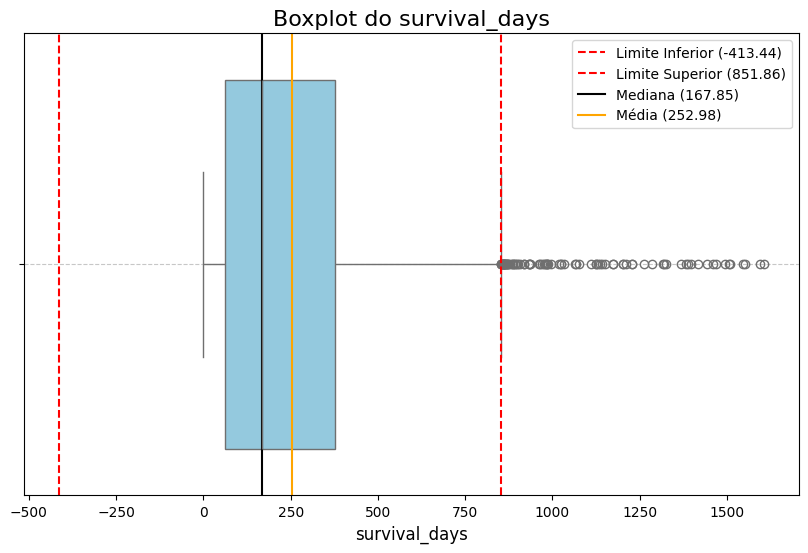

Número de outliers (survival_days): 84


    ID: 8
    Restaurante: Rei do Peixe
    Dias de Sobrevivência: 1605.2053773340856481
    Apagado : Não
    

    ID: 11
    Restaurante: Pop Motel
    Dias de Sobrevivência: 964.8849977314814815
    Apagado : Sim
    

    ID: 13
    Restaurante: Top Sushi
    Dias de Sobrevivência: 1593.8958198109375000
    Apagado : Não
    

    ID: 19
    Restaurante: Taberna 91
    Dias de Sobrevivência: 1551.3188154012152778
    Apagado : Não
    

    ID: 20
    Restaurante: Caffè Lorenzon
    Dias de Sobrevivência: 1545.2762298803819444
    Apagado : Não
    

    ID: 21
    Restaurante: CAFÉ ILLU
    Dias de Sobrevivência: 893.9665678009259259
    Apagado : Sim
    

    ID: 23
    Restaurante: Chefs Burger
    Dias de Sobrevivência: 1387.0688403356481481
    Apagado : Sim
    

    ID: 29
    Restaurante: Rosa Náutica 
    Dias de Sobrevivência: 1508.1531499729745370
    Apagado : Não
    

    ID: 32
    Restaurante: Wine Garden
    Dias de Sobrev

In [3]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


survival_days_data = final_df['survival_days'].fillna(0).astype(float)

# Cálculos de estatísticas
q1 = np.percentile(survival_days_data, 25)
q3 = np.percentile(survival_days_data, 75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = final_df[(final_df['survival_days'].astype(float) < limite_inferior) | (final_df['survival_days'].astype(float) > limite_superior)]



# Plot do boxplot usando seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=survival_days_data, color='skyblue')

# Adicionando anotações sobre limites
plt.axvline(x=limite_inferior, color='red', linestyle='--', label=f"Limite Inferior ({limite_inferior:.2f})")
plt.axvline(x=limite_superior, color='red', linestyle='--', label=f"Limite Superior ({limite_superior:.2f})")
plt.axvline(x=np.median(survival_days_data), color='black', linestyle='-', label=f"Mediana ({np.median(survival_days_data):.2f})")
plt.axvline(x=np.mean(survival_days_data), color='orange', linestyle='-', label=f"Média ({np.mean(survival_days_data):.2f})")

# Configuração do gráfico
plt.title("Boxplot do survival_days", fontsize=16)
plt.xlabel("survival_days", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Número de outliers (survival_days): {len(outliers)}\n")

for index, row in outliers.iterrows():
    print(f'''
    ID: {row['restaurant_id']}
    Restaurante: {row['fantasy_name']}
    Dias de Sobrevivência: {row['survival_days']}
    Apagado : {'Sim' if row['is_deleted'] == 1 else 'Não'}
    ''')


print(f'Média dos Outliers em anos :{np.mean(outliers[['survival_days']])/365:.2f}')
print(f'Média dos Outliers em dias :{np.mean(outliers[['survival_days']]):.2f}')

## Preparando os dados para o treinamento do Modelo



In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#### Verificando valores ausentes nas caractéristicas preditoras

In [5]:
features_to_impute = [
 'has_club', 'has_ifood',
       'is_multistore_related', 'has_fiscal', 'only_delivery',
       'sessions_count', 'mrr', 'total_users', 'soma_ult_sem', 'soma_sem_anterior',
       'soma_2_sem_anteriores', 'variance_x', 'std_dev_x', 'comandas_ult_sem',
       'comandas_sem_anterior', 'comandas_2_sem_anteriores', 'variance_y',
       'std_dev_y', 'average_table_session'
]
missing_values = df[features_to_impute].isnull().sum()

missing_values

has_club                        0
has_ifood                       0
is_multistore_related           0
has_fiscal                      0
only_delivery                   0
sessions_count                  0
mrr                          1163
total_users                     0
soma_ult_sem                  508
soma_sem_anterior             508
soma_2_sem_anteriores         508
variance_x                    508
std_dev_x                     508
comandas_ult_sem              508
comandas_sem_anterior         508
comandas_2_sem_anteriores     508
variance_y                    508
std_dev_y                     508
average_table_session         448
dtype: int64

### Preenchendo valores ausentes com a média da sua respectiva coluna e separando as caracteristicas alvo :

##### 'survival_days' , dias de sobrevicência até o cancelamento
##### 'is_deleted' , se foi deletado(1) ou não(0)

In [6]:
imputer = SimpleImputer()

X_to_impute = df[features_to_impute]
X_imputed = imputer.fit_transform(X_to_impute)




y_time = df['survival_days'].astype(float)  # Tempo até o evento
y_event = df['is_deleted'].astype(bool)    # Churn ocorreu ou não

scaler = StandardScaler()
X_scaled=scaler.fit_transform(X_imputed)

##### Construindo o modelo Random Survival Forrest

##### Diferenças entre o RF e o RSF

RF:
A variável alvo é uma classe (classificação) ou um valor contínuo (regressão).

RSF:
A variável alvo é composta por dois componentes:

O tempo até o evento (
𝑦
𝑖
 ).
O indicador de censura (
𝛿
𝑖
), que especifica se o evento foi observado (
𝛿
𝑖
=1) ou censurado (
𝛿
𝑖 =0).

RF:

Usa critérios como:

Gini Impurity (para classificação) ou
MSE (Mean Squared Error) (para regressão) para decidir onde dividir os nós nas árvores.


RSF:

Modifica o critério de divisão para considerar os tempos de sobrevivência e a censura. 
Um critério comum no RSF é a estatística log-rank, que mede a separação dos tempos de sobrevivência entre os grupos resultantes em um nó.



## Resultado Final 

RF:

Produz predições diretas:

Classes (classificação).
Valores contínuos (regressão).


RSF:

Gera uma função de sobrevivência 
𝑆
(
𝑡
 ) para cada observação, que representa a probabilidade de sobreviver além de cada tempo 
𝑡
. Essa função é construída a partir das árvores individuais:

Cada árvore contribui com uma estimativa 
𝑆
^
(
𝑡
)
.

A função final é a média das funções de sobrevivência de todas as árvores.


In [7]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=20,max_depth=10, random_state=42)

### Speração dos dados, treinamento e validação 

#####  Validação Cruzada com 5 Klusters(Grupos de Dados)

In [8]:



y = Surv.from_arrays(event=y_event, time=y_time)

from sklearn.model_selection import KFold



kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []
i = 0
for train_idx, test_idx in kf.split(X_scaled):

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    

    rsf.fit(X_train, y_train)
    

    surv_preds = rsf.predict_survival_function(X_test)
    c_index = rsf.score(X_test, y_test)
    print(f'C-Index no Kluster {i+1}:{c_index:.4f}')
    c_index_scores.append(c_index)
    i+=1

print(f"C-Index médio: {np.mean(c_index_scores):.4f}")



C-Index no Kluster 1:0.8385
C-Index no Kluster 2:0.8475
C-Index no Kluster 3:0.8462
C-Index no Kluster 4:0.8380
C-Index no Kluster 5:0.8490
C-Index médio: 0.8439


## Concordance Index (C-index)


\begin{aligned} c = \dfrac{\sum_{i \neq j} 1 \{ \eta_i < \eta_j \} 1 \{ T_i > T_j \} d_j }{\sum_{i \neq j} 1 \{ T_i > T_j \} d_j }. \end{aligned}



### Componentes

𝑖
e
𝑗 
representam dois restaurantes.

Estamos analisando todos os pares possíveis (
𝑖
≠
𝑗
).

1{𝜂
𝑖
​
 <𝜂 
𝑗
​
 }: Indica que o escore predito η para o restaurante 
𝑖
 é menor que o de 
𝑗
. 

1{T𝑖>T 𝑗}: Indica que o tempo observado 
𝑇
para 
𝑖
 é maior que o de 
𝑗
. Isso reflete a ordem verdadeira dos tempos de sobrevivência.

d 
𝑗
​
 : Indicador de censura. Vale 1 se o evento ocorreu para 
𝑗
, ou seja, 
𝑗
 não é censurado. Isso garante que apenas pares não censurados sejam usados no cálculo.


### Numerador:

 Soma de todas as comparações concordantes entre os pares 
𝑖
,
𝑗
. Concordância ocorre quando a previsão 
𝜂
𝑖

​
  e a realidade 
𝑇
𝑖
estão alinhadas.

### Denominador
Soma de todos os pares ordenáveis, ou seja, pares onde 
𝑇𝑖>𝑇𝑗  e o evento para 
𝑗
 foi observado (
𝛿
𝑗 =1).






#### De maneira simplificada

\begin{aligned} c = \dfrac{\# \text{ concordant pairs}}{\# \text{ concordant pairs} + \# \text{ discordant pairs}}. \end{aligned}


## Permutação de Importância das Características


In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean
sorted_indices = np.argsort(importances)[::-1]

# Mostrar as características mais importantes
for i in sorted_indices:
    print(f"Feature: {features_to_impute[i]}, Importance: {importances[i]}")

Feature: sessions_count, Importance: 0.17524102564102562
Feature: mrr, Importance: 0.03534358974358973
Feature: is_multistore_related, Importance: 0.007605429864253365
Feature: variance_y, Importance: 0.006561689291101014
Feature: soma_ult_sem, Importance: 0.006194268476621389
Feature: total_users, Importance: 0.005721266968325778
Feature: comandas_ult_sem, Importance: 0.005545098039215668
Feature: variance_x, Importance: 0.004031975867269966
Feature: std_dev_y, Importance: 0.003367722473604806
Feature: comandas_2_sem_anteriores, Importance: 0.002509200603318218
Feature: soma_2_sem_anteriores, Importance: 0.002466365007541449
Feature: average_table_session, Importance: 0.0020343891402714643
Feature: has_club, Importance: 0.0018015082956259199
Feature: std_dev_x, Importance: 0.0016971342383106935
Feature: comandas_sem_anterior, Importance: 0.0008693815987933284
Feature: has_fiscal, Importance: 0.0002135746606334532
Feature: has_ifood, Importance: 0.00018220211161386058
Feature: only_del

# Kapplan - Meier

A curva de Kaplan-Meier estima a função de sobrevivência 
𝑆
(
𝑡
)
, que é a probabilidade de um indivíduo sobreviver além de um determinado tempo 
𝑡
. É amplamente usada porque pode lidar com dados censurados, ou seja, observações onde o tempo de evento não é conhecido exatamente.

𝑆(𝑡)=𝑃(𝑇>𝑡)




$$
\hat{S}(t) = \prod_{i:t_i \leq t} \left( 1 - \frac{d_i}{n_i} \right)
$$


𝑡𝑖:Tempo de um evento observado (cancelamento).

𝑑𝑖:Número de eventos no tempo 𝑡𝑖.

𝑛𝑖
​
 : Número de indivíduos em risco no tempo 
𝑡
𝑖(ou seja, aqueles que ainda não experimentaram o evento nem foram censurados antes de 𝑡𝑖)

## Validação por Brier-Score

In [10]:
from sksurv.metrics import brier_score

import numpy as np

surv_funcs = rsf.predict_survival_function(X_test)


y_test_structured = np.array(

    [(event, time) for event, time in y_test],
    dtype=[("event", bool), ("time", float)]

)



y_train_structured = np.array(

    [(event, time) for event, time in y_train],
    dtype=[("event", bool), ("time", float)]
)



time_horizons = np.arange(1,1500,0.5)
surv_probs = np.array([[fn(t) for t in time_horizons] for fn in surv_funcs ])


        


# Calcular o Brier Score
times, brier_scores = brier_score(y_train_structured, y_test_structured, surv_probs, time_horizons)


print(np.mean(brier_scores))

0.08932771713035588


# Brier-Score para dados censurados e não censurados

$$
BS^c(t) = \frac{1}{n} \sum_{i=1}^{n} \left[ \mathbb{I}(y_i \leq t \land \delta_i = 1) \frac{(0 - \hat{\pi}(t \mid \mathbf{x}_i))^2}{\hat{G}(y_i)} + \mathbb{I}(y_i > t) \frac{(1 - \hat{\pi}(t \mid \mathbf{x}_i))^2}{\hat{G}(t)} \right]
$$


No cálculo do Brier Score ajustado para censura, o Kaplan-Meier é usado para estimar 
𝐺
^
(
𝑡
)
, a probabilidade de não censura até o tempo 
𝑡
.

n: Número total de observações.

𝐼(⋅): Função indicadora que retorna 1 se a condição for verdadeira e 0 caso contrário.

𝑦𝑖: Tempo de sobrevivência do restaurante 𝑖

𝛿𝑖: Indicador de censura para o indivíduo 𝑖(1 se o evento ocorreu, 0 se censurado).

𝜋^(𝑡∣𝑥𝑖): Probabilidade predita de sobrevivência até o tempo 𝑡 para o indivíduo 𝑖, 
dado seu vetor de características 𝑥𝑖.

𝐺^(𝑡): Estimativa da função de distribuição acumulada de Kaplan-Meier no tempo 𝑡, 
representando a probabilidade de não censura até 𝑡.

O termo é ajustado pela estimativa de censura 𝐺^(𝑦𝑖), que controla para os indivíduos censurados no conjunto de dados.


## Demaneira Geral 



##### Quanto mais próximo de zero melhor

### Brier-Score para os dias preditos

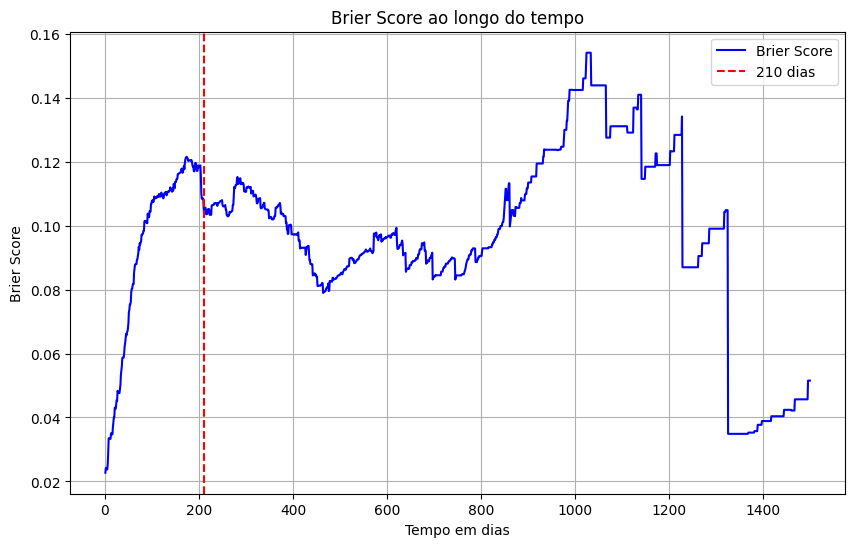

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, brier_scores, label="Brier Score", color="blue")
plt.axvline(x=210, color="red", linestyle="--", label="210 dias")
plt.xlabel("Tempo em dias")
plt.ylabel("Brier Score")
plt.title("Brier Score ao longo do tempo")
plt.legend()
plt.grid()
plt.show()

# Log-Rank

O Log-Rank Test também depende da curva Kaplan-Meier, mas com um propósito diferente: comparar duas ou mais curvas de sobrevivência.


$$
\chi^2 = \frac{\left(\sum_{i} (O_i - E_i)\right)^2}{\sum_{i} V_i}
$$


𝑂𝑖:Número de eventos observados no grupo 𝑖.

𝐸𝑖:Número de eventos esperados no grupo 𝑖, dado o tamanho do grupo e a função de sobrevivência geral.

𝑉𝑖:Variância da diferença (𝑂𝑖−𝐸𝑖).



## Como funciona:

Para cada tempo 𝑖 onde ocorre um evento, calcula-se o número esperado de eventos em cada grupo com base no número total de indivíduos em risco naquele tempo.

Soma-se as diferenças entre o número observado e esperado para todos os tempos.

A estatística final verifica se as diferenças entre os grupos são grandes o suficiente para rejeitar a hipótese nula (que assume que as curvas de sobrevivência são iguais).

### Interpretação do Log-Rank Test

##### Estatística 𝜒2: 

Mede o desvio acumulado entre os eventos observados e esperados, ajustado pela variância.

Um 𝜒2 alto sugere que há uma diferença significativa entre as curvas de sobrevivência dos grupos.


##### Valor-p:

A partir de 𝜒2, calculamos o valor-p usando uma distribuição qui-quadrado com 1 grau de liberdade (para duas curvas) ou 
𝑘 − 1 graus de liberdade (para 𝑘 curvas).


-> Hipótese nula:

𝐻0: Não há diferença significativa entre as curvas de sobrevivência.

Se o valor-p é menor que o nível de significância (ex.: 𝛼=0.05), rejeitamos 𝐻0, indicando que as curvas são significativamente diferentes.

## Comparação com KMF e Log-Rank de restaurantes 

Estatistica Ifood: 87.6115726770966
P-value Ifood: 7.965720621739776e-21
Estatistica Clube: 63.47214245524344
P-value Clube: 1.6265080127775191e-15
Há uma diferença estatisticamente significativa entre os grupos(CLUBE).
Há uma diferença estatisticamente significativa entre os grupos(IFOOD).


/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually conver

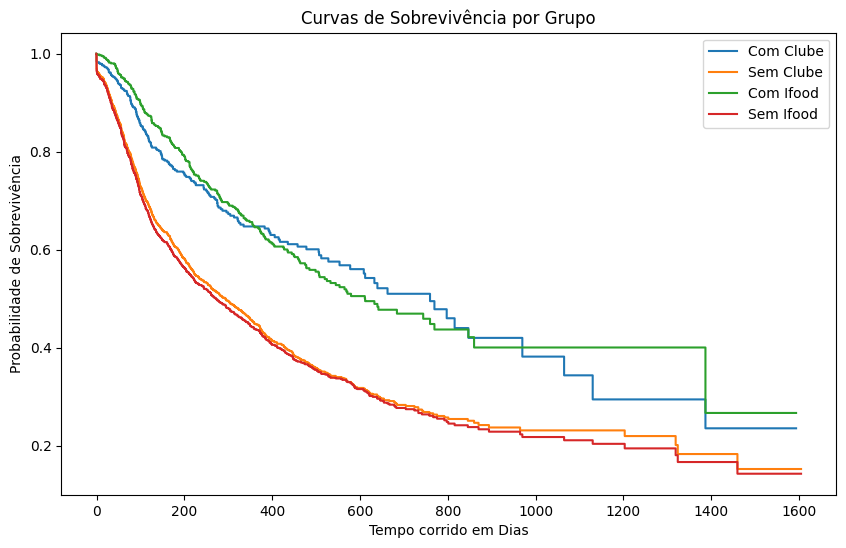

In [13]:
from lifelines.statistics import KaplanMeierFitter,logrank_test

clientes_clube = df[df['has_club']==1]
clientes_sem_clube = df[df['has_club']==0]
clientes_ifood = df[df['has_ifood'] == 1]
clientes_sem_ifood = df[df['has_ifood']==0]

results_clube = logrank_test(clientes_clube['survival_days'].astype(float),
                       clientes_sem_clube['survival_days'].astype(float),
                       event_observed_A=clientes_clube['is_deleted'],
                       event_observed_B=clientes_sem_clube['is_deleted']
                       
                       )

results_ifood = logrank_test(clientes_ifood['survival_days'].astype(float),
                       clientes_sem_ifood['survival_days'].astype(float),
                       event_observed_A=clientes_ifood['is_deleted'],
                       event_observed_B=clientes_sem_ifood['is_deleted'])



print(f'Estatistica Ifood: {results_ifood.test_statistic}')
print(f'P-value Ifood: {results_ifood.p_value}')

print(f'Estatistica Clube: {results_clube.test_statistic}')
print(f'P-value Clube: {results_clube.p_value}')



if results_clube.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(CLUBE).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(CLUBE).")


if results_ifood.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(IFOOD).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(IFOOD).")


kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))


kmf.fit(clientes_clube['survival_days'], event_observed=clientes_clube['is_deleted'], label="Com Clube")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_clube['survival_days'], event_observed=clientes_sem_clube['is_deleted'], label="Sem Clube")
kmf.plot_survival_function(ci_show = False)


kmf.fit(clientes_ifood['survival_days'], event_observed=clientes_ifood['is_deleted'], label="Com Ifood")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_ifood['survival_days'], event_observed=clientes_sem_ifood['is_deleted'], label="Sem Ifood")
kmf.plot_survival_function(ci_show = False)

plt.title("Curvas de Sobrevivência por Grupo")
plt.xlabel("Tempo corrido em Dias")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()
plt.show()

  

Estatistica Delivery e Ifood: 1.411272519283743
P-value Delivery e Ifood: 0.23484526264333033
Estatistica Clube e Multilojas: 13.910885161200989
P-value Clube e Multilojas: 0.0001916851363723515
Há uma diferença estatisticamente significativa entre os grupos(CLUBE e MULTILOJAS).
Não há diferença estatisticamente significativa entre os grupos(DELIVERY E IFOOD).


/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually conver

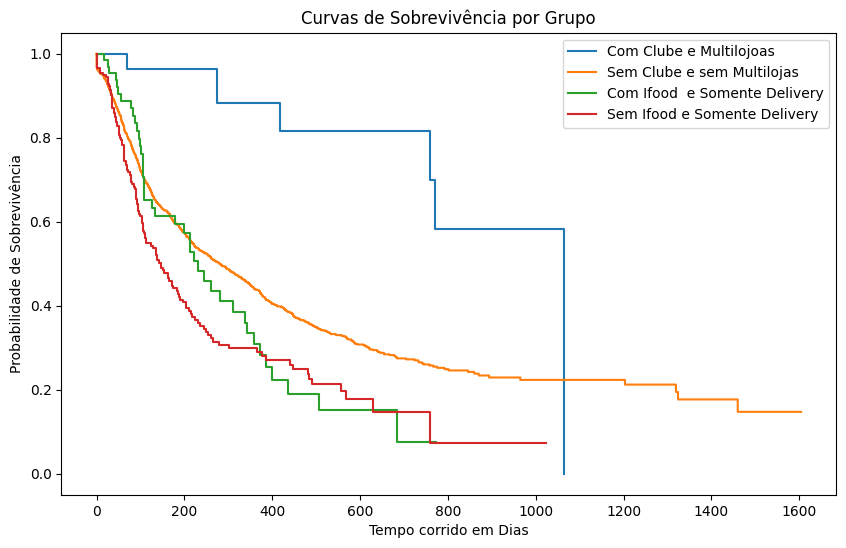

In [ ]:
from lifelines.statistics import KaplanMeierFitter,logrank_test

clientes_clube_and_multistore = df[(df['has_club'] == 1) & (df['is_multistore_related'] == 1)]

clientes_sem_clube_and_multistore = df[(df['has_club']==0) & (df['is_multistore_related']==0)]

clientes_ifood = df[(df['has_ifood'] == 1) & (df['only_delivery'] == 1 )]
clientes_sem_ifood = df[(df['has_ifood']==0) & (df['only_delivery'] == 1)  ]

results_clube_and_multistore = logrank_test(clientes_clube_and_multistore['survival_days'].astype(float),
                       clientes_sem_clube_and_multistore['survival_days'].astype(float),
                       event_observed_A=clientes_clube_and_multistore['is_deleted'],
                       event_observed_B=clientes_sem_clube_and_multistore['is_deleted']
                       
                       )

results_ifood = logrank_test(clientes_ifood['survival_days'].astype(float),
                       clientes_sem_ifood['survival_days'].astype(float),
                       event_observed_A=clientes_ifood['is_deleted'],
                       event_observed_B=clientes_sem_ifood['is_deleted'])



print(f'Estatistica Delivery e Ifood: {results_ifood.test_statistic}')
print(f'P-value Delivery e Ifood: {results_ifood.p_value}')

print(f'Estatistica Clube e Multilojas: {results_clube_and_multistore.test_statistic}')
print(f'P-value Clube e Multilojas: {results_clube_and_multistore.p_value}')



if results_clube_and_multistore.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(CLUBE e MULTILOJAS).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(CLUBE e MULTILOJAS).")


if results_ifood.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(DELIVERY E IFOOD).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(DELIVERY E IFOOD).")


kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))


kmf.fit(clientes_clube_and_multistore['survival_days'], event_observed=clientes_clube_and_multistore['is_deleted'], label="Com Clube e Multilojoas")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_clube_and_multistore['survival_days'], event_observed=clientes_sem_clube_and_multistore['is_deleted'], label="Sem Clube e sem Multilojas")
kmf.plot_survival_function(ci_show = False)


kmf.fit(clientes_ifood['survival_days'], event_observed=clientes_ifood['is_deleted'], label="Com Ifood  e Somente Delivery")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_ifood['survival_days'], event_observed=clientes_sem_ifood['is_deleted'], label="Sem Ifood e Somente Delivery")
kmf.plot_survival_function(ci_show = False)

plt.title("Curvas de Sobrevivência por Grupo")
plt.xlabel("Tempo corrido em Dias")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()
plt.show()

  

In [12]:
df_clube = df[(df['has_club']== 1) & (df['is_multistore_related'] == 1)]


for index,row in df_clube.iterrows():
        print(f'''
    ID: {row['restaurant_id']}
    Restaurante: {row['fantasy_name']}
    Dias de Sobrevivência: {row['survival_days']}
    Apagado : {'Sim' if row['is_deleted'] == 1 else 'Não'}
    Multilojas : {'Sim' if row['is_multistore_related'] == 1 else 'Não'}
    Tem Clube : {'Sim' if row['has_club'] == 1 else 'Não'}
    ''')
print(f'Restaurantes com clube e são parte do multilojas: {len(df_clube)}')


    ID: 144
    Restaurante: Franguinho Gru
    Dias de Sobrevivência: 1065.1153817824074074
    Apagado : Sim
    Multilojas : Sim
    Tem Clube : Sim
    

    ID: 279
    Restaurante: Elisios Burger e Grelhados
    Dias de Sobrevivência: 873.3546193903935185
    Apagado : Não
    Multilojas : Sim
    Tem Clube : Sim
    

    ID: 281
    Restaurante: Franguinho Villas 
    Dias de Sobrevivência: 769.7171494560185185
    Apagado : Sim
    Multilojas : Sim
    Tem Clube : Sim
    

    ID: 296
    Restaurante: Mark - Cidade Baixa
    Dias de Sobrevivência: 864.6959470524305556
    Apagado : Não
    Multilojas : Sim
    Tem Clube : Sim
    

    ID: 314
    Restaurante: Mark - Zona Sul
    Dias de Sobrevivência: 851.7318948070601852
    Apagado : Não
    Multilojas : Sim
    Tem Clube : Sim
    

    ID: 321
    Restaurante: Mark - Bom Fim
    Dias de Sobrevivência: 849.6915561380787037
    Apagado : Não
    Multilojas : Sim
    Tem Clube : Sim
    

    ID: 328
    Restaurante: Oca d